# Part 3 - Performance Testing

### Overview

Now that we can classify SMS messages using both the foundation GPT model and our fine tuned models, we want to test them to see if there are performance and cost differences.

The following steps are covered:

* Set up classification APIs for both fine-tuned and foundation models (re-used from Part 1 and Part 2)
* Predict on the validation data for each model
* Look at performance via confusion matrix

In [2]:
# Install dependencies if needed
# %pip install pandas
# %pip install python-dotenv
# %pip install openai --upgrade
# %pip install throttler
# %pip install matplotlib
# %pip install seaborn

### Resources

* https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

In [3]:
from openai import OpenAI
import os
import json
import pandas as pd
import time
import datetime

In [4]:
from dotenv import load_dotenv; load_dotenv()
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [16]:
# Sample Size to Model ID

# Copy/paste this dictionary in from the Part 1 notebook where the models are trained
# It will be output from the final cell so you can just copy/paste it here

fine_tuned_models = {
    10: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBJIU02',
    15: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBKfVCh',
    20: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBTXhIj',
    25: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBTuMaq',
    30: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBgIVeX',
    35: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBfhbX6',
    40: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBqnboO',
    45: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBtje7h',
    50: 'ft:gpt-3.5-turbo-1106:hypercolor::8JBwWNER',
    60: 'ft:gpt-3.5-turbo-1106:hypercolor::8JC9mQ5T',
    70: 'ft:gpt-3.5-turbo-1106:hypercolor::8JCDiUJu',
    80: 'ft:gpt-3.5-turbo-1106:hypercolor::8JCJ48nL',
    90: 'ft:gpt-3.5-turbo-1106:hypercolor::8JCYhUyu',
    100: 'ft:gpt-3.5-turbo-1106:hypercolor::8JCf0Fge',
    200: 'ft:gpt-3.5-turbo-1106:hypercolor::8JDE3R1k'
 }

# Define Classification APIs

These APIs take an input message and use either a fine-tuned model or the foundation model to predict whether it is spam.  Each returns a boolean: True for spam.

In [6]:
# Fine Tuned Model API

fineTunePrompt = "You are a system for categorizing SMS text messages as being unwanted spam or normal messages."

def getSpamClassification_FineTune(fineTunedModelId, prompt):
    completion = client.chat.completions.create(
        model=fineTunedModelId,
        messages=[
        {"role": "system", "content": fineTunePrompt},
        {"role": "user", "content": prompt}
        ],
        timeout=15
    )
    if completion.choices[0].message.content.lower() == 'spam':
        return True
    elif completion.choices[0].message.content.lower() == 'ham':
        return False
    else:
        raise Exception("Invalid response: {}".format(completion.choices[0].message.content))



In [7]:
# Foundation Model API

foundationModelPrompt = """
You are a spam classifier. 
Your job is to examine the content of a message and determine if it is spam or ham. 
Spam is a message that is spam, harmful, abusive, an attempt to access private information, harrassment, or otherwise unwanted. 
Ham is any message that is not classified as spam.
Response should be a single word: Spam or Ham.
"""

def getSpamClassification_FoundationModel(message):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": foundationModelPrompt},
            {"role": "user", "content": message}
        ],
        temperature=0.5,
        max_tokens=2,
        timeout=15
    )
    if completion.choices[0].message.content.lower() == 'spam':
        return True
    elif completion.choices[0].message.content.lower() == 'ham':
        return False
    else:
        raise Exception("Invalid response: {}".format(completion.choices[0].message.content))

# Predict on Validation Data

Each fine-tuned model has a validation dataset in addition to its training data.  Here we predict on those datasets for each fine tuned model and the foundation model.

Predicting on the entire validation set takes some time.  OpenAI has rate limiting, and it's not free, so it's not something we want to do more than once.

https://platform.openai.com/docs/guides/rate-limits

To make this process robust to things like network errors, we start by creating a dataframe that contains the validation data and a blank column for the results.  The code will run predictions for each row that has an empty result.  This means that this code can be restarted in case of failure.  Additionally, to avoid having to re-run all the predictions in case of kernel restart, we save the resulting dataframe to file where it can be optionally reloaded.

In other words, if your Jupyter crashes or errors out during the validation, you can simply hit "Run All" again at the top and it will pick back up where it left off.

In [12]:
# This cell prepares the dataframe that will hold the predictions

rows1 = []
rows2 = []

IncompletePredictionSentinel = "-"

models_to_test = [10,30,50]
# models_to_test = [10,20,30,40,50,60,70,80,90,100,200]
# models_to_test = [10,25,50,100,200]

# To test this on a smaller dataset, we can optionally use "[:5]" to take only the first 5 lines
validation_data_path = f"../data/temp/validation.jsonl"
with open(validation_data_path, 'r') as f:
    # for line in f.readlines()[:5]:
    for line in f.readlines()[:100]:
    # for line in f.readlines():
        data = json.loads(line)
        prompt = data['messages'][1]['content']
        completion = data['messages'][2]['content']
        rows2.append({
            'model': 'foundation',
            'sample_size': 0,
            'prompt': prompt,
            'expected': completion == 'spam',
            'predicted': IncompletePredictionSentinel
        })   
        for sample_size in models_to_test:
            rows1.append({
                'model': fine_tuned_models[sample_size],
                'sample_size': sample_size,
                'prompt': prompt,
                'expected': completion == 'spam',
                'predicted': IncompletePredictionSentinel
            }) 

validation_df = pd.DataFrame(rows1+rows2)
print("Prepared empty validation dataframe with {} rows".format(len(validation_df)))           

Prepared empty validation dataframe with 1200 rows


In [8]:
# If a previous result is available, we can optionally load it here instead of re-running the validation
validation_df = pd.read_csv('../data/temp/validation_results.csv')
print("Loaded validation data, {} items remaining".format(validation_df['predicted'].eq(IncompletePredictionSentinel).sum()))    
# validation_df

Loaded validation data, 518 items remaining


In [13]:
# Note: Running this cell will take a while and incur API usage costs

# Use Throttler to limit the number of requests per minute
from throttler import Throttler
# throttler = Throttler(rate_limit=19, period=20) # Use for rate limit 60/min
throttler = Throttler(rate_limit=3000, period=60) # Use for rate limit 3500/min

print("Running validation, {} items remaining".format(validation_df['predicted'].eq(IncompletePredictionSentinel).sum()))     

start = time.time()
for index, row in validation_df.iterrows():
    if row['predicted'] == IncompletePredictionSentinel:
        async with throttler:
            elapsedSeconds = time.time() - start
            if row['model'] == 'foundation':
                result = getSpamClassification_FoundationModel(row['prompt'])
            else:
                result = getSpamClassification_FineTune(row['model'], row['prompt'])
            print("{}  Predicted on validation row {} / {} with model: {}: {} - {}".format(str(datetime.timedelta(seconds=elapsedSeconds)), index+1, len(validation_df), row['sample_size'], result, row['prompt'][:50]))
        validation_df.loc[index, 'predicted'] = result

        # Save to disk after every prediction in case we need to interrupt kernel and resume
        validation_df.to_csv('../data/temp/validation_results.csv', index=False)


validation_df['predicted'] = validation_df['predicted'].astype(bool)
validation_df['correct'] = validation_df['expected'] == validation_df['predicted']
validation_df.to_csv('../data/temp/validation_results.csv', index=False)

print("Saved validation results to ../data/temp/validation_results.csv")
# validation_df.head()


Running validation, 1200 items remaining
0:00:00.000564  Predicted on validation row 1 / 1200 with model: 10: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:00.714856  Predicted on validation row 2 / 1200 with model: 20: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:01.027595  Predicted on validation row 3 / 1200 with model: 30: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:01.359641  Predicted on validation row 4 / 1200 with model: 40: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:01.674316  Predicted on validation row 5 / 1200 with model: 50: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:01.951334  Predicted on validation row 6 / 1200 with model: 60: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:02.534945  Predicted on validation row 7 / 1200 with model: 70: True - Do you want a New Nokia 3510i colour phone Deliver
0:00:02.799857  Predicted on validation row 8 / 1200 with model: 80: T

# Generate Confusion Matrix

* Accuracy: % correct
* Recall: % of "positives" that are correct - important when FP are expensive
* Precision: % of "true" that you are missing - important when FN are expensive

In [18]:
# Create a confusion matrix for each sample size and model, put them into a dataframe

#%pip install scikit-learn
from sklearn.metrics import confusion_matrix

fineTuneResults = validation_df[validation_df['model'] != 'foundation']
foundationResults = validation_df[validation_df['model'] == 'foundation']
grouped = fineTuneResults.groupby('sample_size')

def compute_cm(df):
    cm = confusion_matrix(df['expected'], df['predicted'], labels=[True, False])
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    recall = tp / (tp + fp)
    precision = tp / (tp + fn)
    return cm, accuracy, recall, precision

rows = []
for sample_size in grouped.groups:
    group = grouped.get_group(sample_size)

    cm, accuracy, recall, precision = compute_cm(group)
    rows.append([sample_size, 'fine-tuned', cm[0][0], cm[0][1], cm[1][0], cm[1][1], accuracy, recall, precision])

cm, accuracy, recall, precision = compute_cm(foundationResults)
rows.append([0, 'foundation', cm[0][0], cm[0][1], cm[1][0], cm[1][1], accuracy, recall, precision])    


confusion_matrix_df = pd.DataFrame(rows, columns=['sample_size', 'model', 'true_positive', 'false_positive', 'false_negative', 'true_negative', 'accuracy', 'recall', 'precision'])
confusion_matrix_df

,sample_size,model,true_positive,false_positive,false_negative,true_negative,accuracy,recall,precision
0,10,fine-tuned,20,5,1,74,0.94,0.80,0.952381
1,20,fine-tuned,23,2,1,74,0.97,0.92,0.958333
2,30,fine-tuned,23,2,0,75,0.98,0.92,1.000000
3,40,fine-tuned,24,1,1,74,0.98,0.96,0.960000
4,50,fine-tuned,24,1,0,75,0.99,0.96,1.000000
5,60,fine-tuned,24,1,4,71,0.95,0.96,0.857143
6,70,fine-tuned,24,1,1,74,0.98,0.96,0.960000
7,80,fine-tuned,25,0,2,73,0.98,1.00,0.925926
8,90,fine-tuned,25,0,3,72,0.97,1.00,0.892857
9,100,fine-tuned,24,1,0,75,0.99,0.96,1.000000


# Generate Learning Curves

The learning curve visualizes the improvement to performance seen as sample size increases

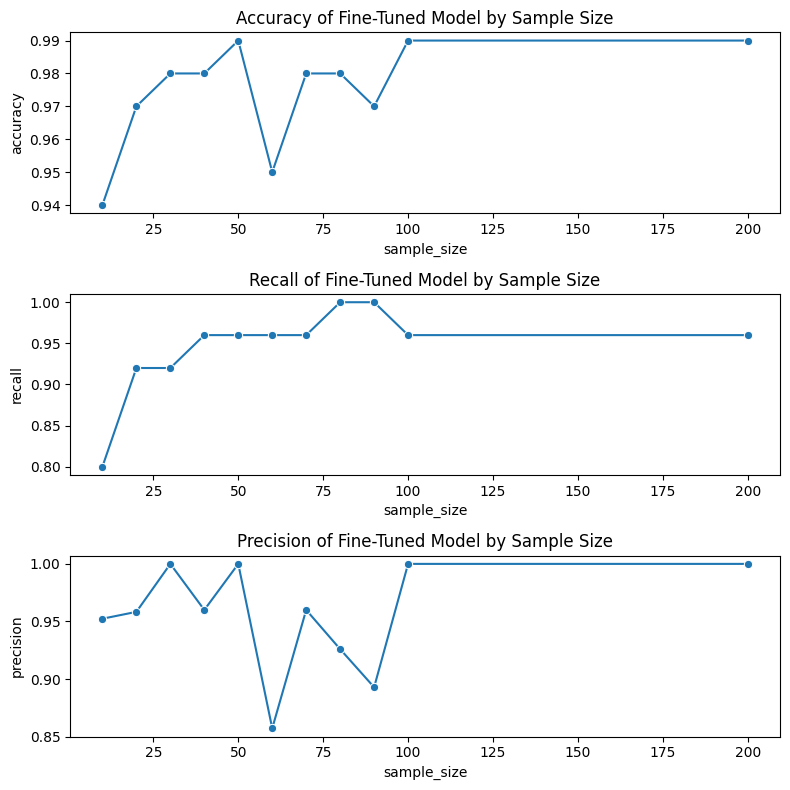

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for 'fine-tuned' model
fine_tuned_df = confusion_matrix_df[confusion_matrix_df['model'] == 'fine-tuned']

# Create a figure with three subplots
fig, axs = plt.subplots(3, figsize=(8, 8))

# Create a line chart for 'accuracy'
sns.lineplot(x='sample_size', y='accuracy', data=fine_tuned_df, marker='o', ax=axs[0])
axs[0].set_title('Accuracy of Fine-Tuned Model by Sample Size')

# Create a line chart for 'recall'
sns.lineplot(x='sample_size', y='recall', data=fine_tuned_df, marker='o', ax=axs[1])
axs[1].set_title('Recall of Fine-Tuned Model by Sample Size')

# Create a line chart for 'precision'
sns.lineplot(x='sample_size', y='precision', data=fine_tuned_df, marker='o', ax=axs[2])
axs[2].set_title('Precision of Fine-Tuned Model by Sample Size')

plt.tight_layout()
plt.show()

# # Create a line chart with visible points
# plt.figure(figsize=(10, 6))
# sns.lineplot(x='sample_size', y='accuracy', data=fine_tuned_df, marker='o')

# plt.title('Accuracy of Fine-Tuned Model by Sample Size')
# plt.show()

# Playground

In [ ]:
getSpamClassification_FineTune('ft:gpt-3.5-turbo-1106:hypercolor::8JBKfVCh', 'Life style garments account no please.')

In [ ]:
# Take a look at incorrect predictions
ft = validation_df[validation_df['model'] != 'foundation']
len(ft)
ft[ft['correct'] == False]

# Exercise

Try adjusting the prompt for the foundation model version to see if you can get the accuracy up to where the fine-tuned model is at.